In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD

In [2]:
def to_datetime(df):
    date = datetime.strptime(df, '%d.%m.%Y')
    return date.strftime("%Y-%m-%d")

In [4]:
df = pd.read_csv('/content/Price Tesla.csv', sep=';')
df['Date'] = df['Date'].apply(lambda x: to_datetime(x))
df = df.sort_values('Date').reset_index(drop=True)

In [5]:
df.head()

,Date,Price,Open,Max,Min
0,2013-03-01,6.93,7.00,7.20,6.85
1,2013-03-04,7.12,6.95,7.17,6.94
2,2013-03-05,7.33,7.20,7.38,7.16
3,2013-03-06,7.54,7.40,7.58,7.39
4,2013-03-07,7.65,7.55,7.73,7.38


In [6]:
df.shape

(1928, 5)

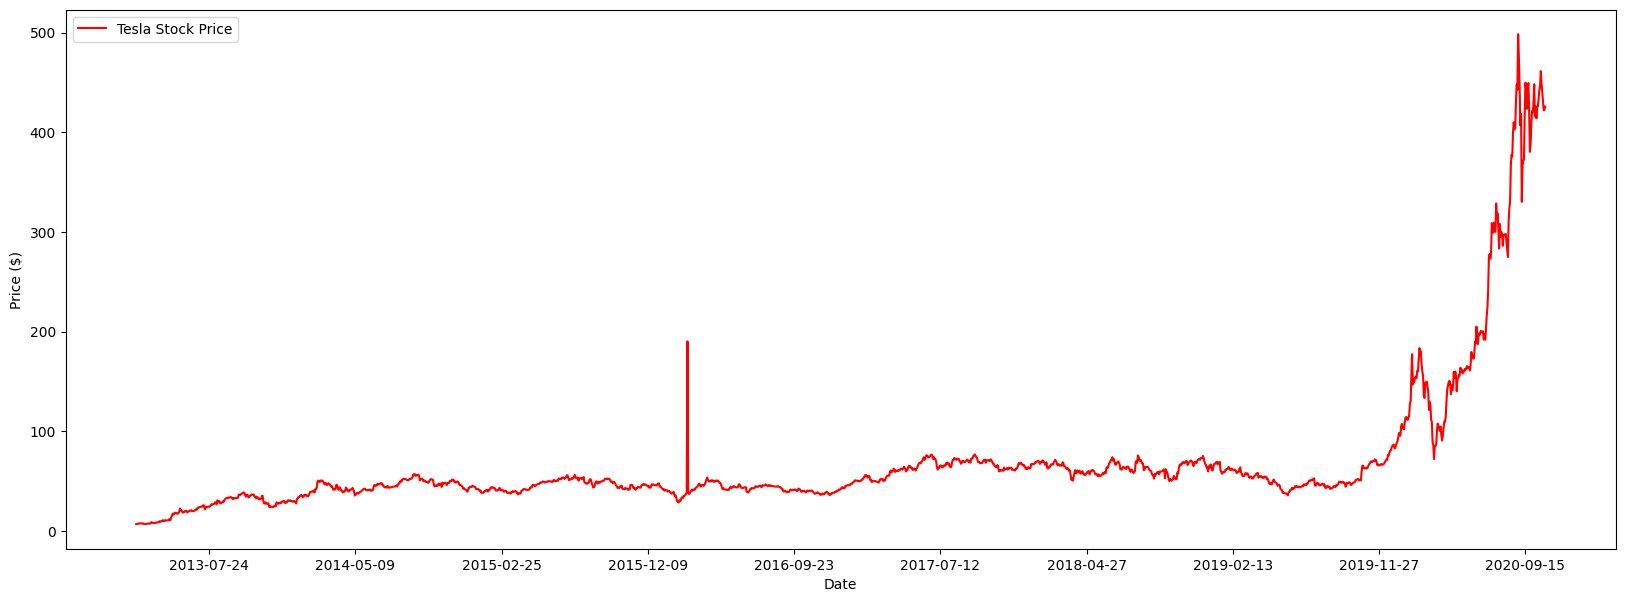

In [7]:
df['Price'] = df['Price'].astype(float)

plt.figure(figsize=(20,7))
plt.plot(df['Date'].values, df['Price'].values, label = 'Tesla Stock Price', color = 'red')
plt.xticks(np.arange(100,df.shape[0],200))
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [8]:
num_shape = 1900

train = df.iloc[:num_shape, 1:2].values
test = df.iloc[num_shape:, 1:2].values

In [9]:
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(train)

In [10]:
X_train = []
y_train = []

window = 60

for i in range(window, num_shape):
    X_train_ = np.reshape(train_scaled[i-window:i, 0], (window, 1))
    X_train.append(X_train_)
    y_train.append(train_scaled[i, 0])
X_train = np.stack(X_train)
y_train = np.stack(y_train)

In [11]:
# Recurrent Neural Network
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [27]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 60, batch_size = 32);

Epoch 1/60
58/58 [==============================] - 19s 148ms/step - loss: 4.0405e-04
Epoch 2/60
58/58 [==============================] - 8s 140ms/step - loss: 5.3532e-04
Epoch 3/60
58/58 [==============================] - 8s 135ms/step - loss: 4.2096e-04
Epoch 4/60
58/58 [==============================] - 9s 153ms/step - loss: 3.7376e-04
Epoch 5/60
58/58 [==============================] - 7s 123ms/step - loss: 3.7264e-04
Epoch 6/60
58/58 [==============================] - 9s 155ms/step - loss: 4.0445e-04
Epoch 7/60
58/58 [==============================] - 7s 121ms/step - loss: 3.9127e-04
Epoch 8/60
58/58 [==============================] - 9s 153ms/step - loss: 3.6081e-04
Epoch 9/60
58/58 [==============================] - 7s 121ms/step - loss: 4.3171e-04
Epoch 10/60
58/58 [==============================] - 9s 155ms/step - loss: 6.1883e-04
Epoch 11/60
58/58 [==============================] - 7s 126ms/step - loss: 4.6185e-04
Epoch 12/60
58/58 [==============================] - 9s 149ms/

In [28]:
df_volume = np.vstack((train, test))

inputs = df_volume[df_volume.shape[0] - test.shape[0] - window:]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

num_2 = df_volume.shape[0] - num_shape + window

X_test = []

for i in range(window, num_2):
    X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
    X_test.append(X_test_)

X_test = np.stack(X_test)

In [31]:
predict = model.predict(X_test)
predict = sc.inverse_transform(predict)

1/1 [==============================] - 0s 58ms/step


In [32]:
diff = predict - test

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

MSE: 959.7093530787853
MAE: 24.330810721261155
RMSE: 30.979176120077586


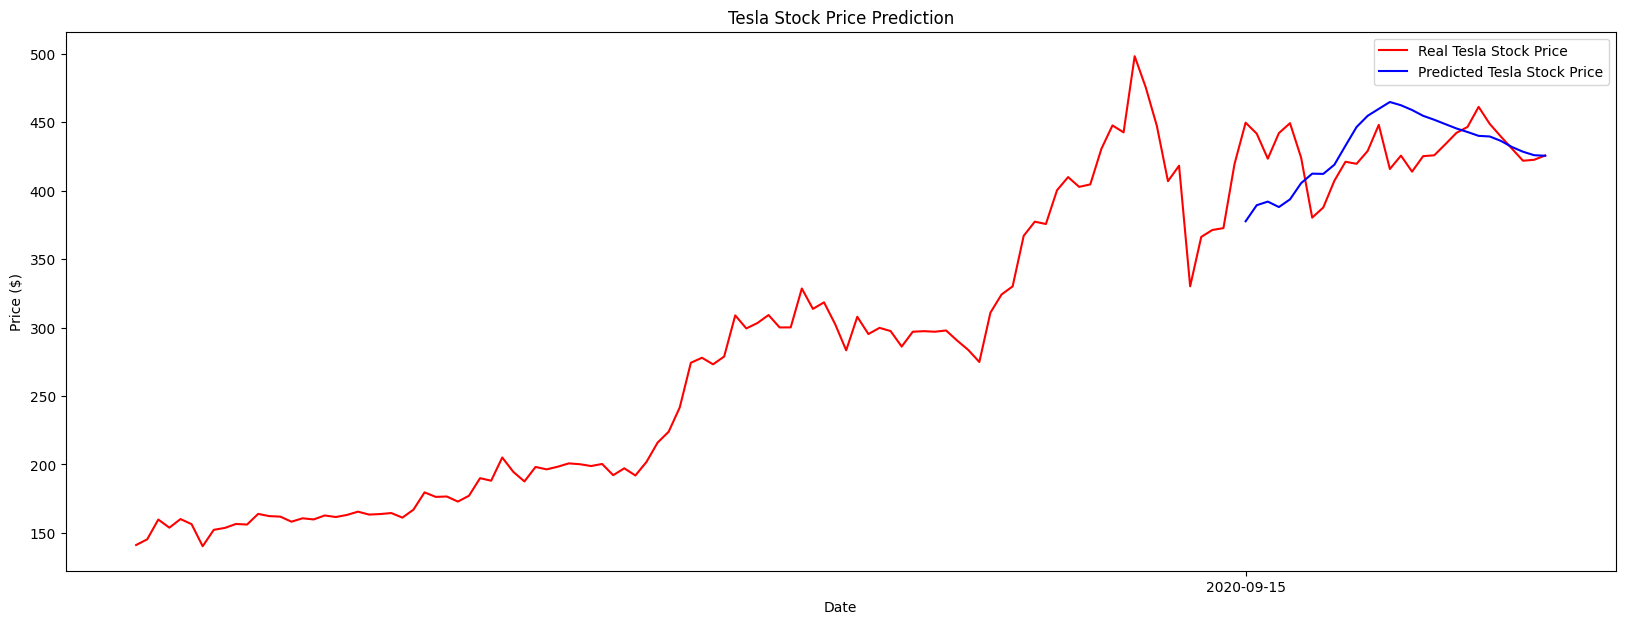

In [33]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[1800:], df_volume[1800:], color = 'red', label = 'Real Tesla Stock Price')
plt.plot(df['Date'][-predict.shape[0]:].values, predict, color = 'blue', label = 'Predicted Tesla Stock Price')
plt.xticks(np.arange(100,df[1800:].shape[0],200))
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [34]:
pred_ = predict[-1].copy()
prediction_full = []
window = 60
df_copy = df.iloc[:, 1:2][1:].values

for j in range(20):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_shape]
    test_ = df_[num_shape:]

    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = model.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

1/1 [==============================] - 0s 47ms/step


In [35]:
prediction_full_new = np.vstack((predict, np.array(prediction_full).reshape(-1,1)))

In [36]:
df_date = df[['Date']]

for h in range(20):
    df_date_add = pd.to_datetime(df_date['Date'].iloc[-1]) + pd.DateOffset(days=1)
    df_date_add = pd.DataFrame([df_date_add.strftime("%Y-%m-%d")], columns=['Date'])
    df_date = df_date.append(df_date_add)
df_date = df_date.reset_index(drop=True)

<ipython-input-36-c275f3152117>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_date = df_date.append(df_date_add)
<ipython-input-36-c275f3152117>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_date = df_date.append(df_date_add)
<ipython-input-36-c275f3152117>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_date = df_date.append(df_date_add)
<ipython-input-36-c275f3152117>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_date = df_date.append(df_date_add)
<ipython-input-36-c275f3152117>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


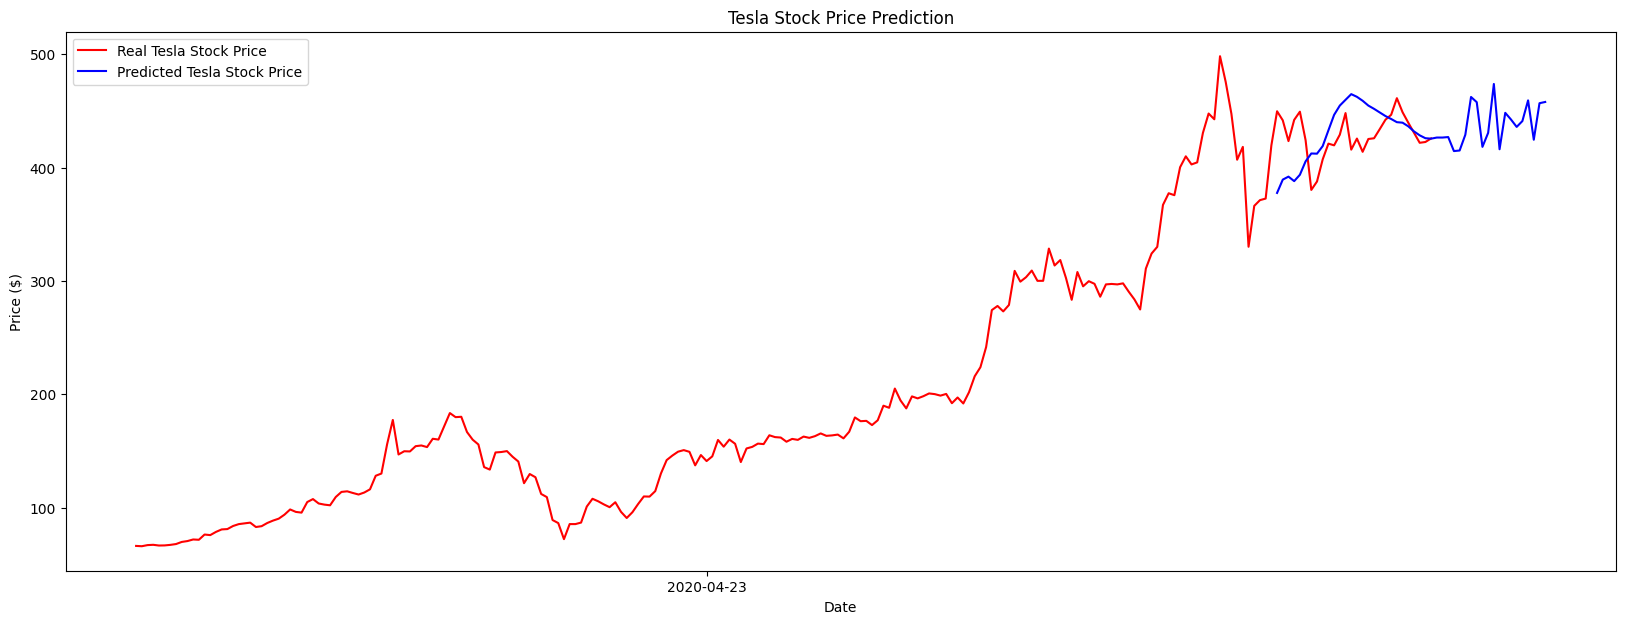

In [37]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[1700:], df_volume[1700:], color = 'red', label = 'Real Tesla Stock Price')
plt.plot(df_date['Date'][-prediction_full_new.shape[0]:].values, prediction_full_new, color = 'blue', label = 'Predicted Tesla Stock Price')
plt.xticks(np.arange(100,df[1700:].shape[0],200))
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [38]:
# The GRU architecture
modelGRU = Sequential()

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50))
modelGRU.add(Dropout(0.2))

modelGRU.add(Dense(units=1))
modelGRU.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 50)            7950      
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 60, 50)            15300     
                                                                 
 dropout_5 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru_2 (GRU)                 (None, 60, 50)            15300     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru_3 (GRU)                 (None, 50)               

In [40]:
modelGRU.compile(optimizer='sgd', loss='mean_squared_error')
modelGRU.fit(X_train, y_train, epochs=60, batch_size=16)

Epoch 1/60
115/115 [==============================] - 16s 90ms/step - loss: 0.0138
Epoch 2/60
115/115 [==============================] - 10s 88ms/step - loss: 0.0124
Epoch 3/60
115/115 [==============================] - 9s 77ms/step - loss: 0.0106
Epoch 4/60
115/115 [==============================] - 10s 91ms/step - loss: 0.0092
Epoch 5/60
115/115 [==============================] - 10s 86ms/step - loss: 0.0078
Epoch 6/60
115/115 [==============================] - 9s 80ms/step - loss: 0.0063
Epoch 7/60
115/115 [==============================] - 10s 91ms/step - loss: 0.0052
Epoch 8/60
115/115 [==============================] - 10s 84ms/step - loss: 0.0040
Epoch 9/60
115/115 [==============================] - 10s 88ms/step - loss: 0.0032
Epoch 10/60
115/115 [==============================] - 11s 97ms/step - loss: 0.0022
Epoch 11/60
115/115 [==============================] - 10s 90ms/step - loss: 0.0018
Epoch 12/60
115/115 [==============================] - 9s 77ms/step - loss: 0.0013
Epoc

In [41]:
predict = modelGRU.predict(X_test)
predict = sc.inverse_transform(predict)

1/1 [==============================] - 5s 5s/step


In [42]:
diff = predict - test

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

MSE: 460.76398197982417
MAE: 17.060944431849887
RMSE: 21.465413622379238


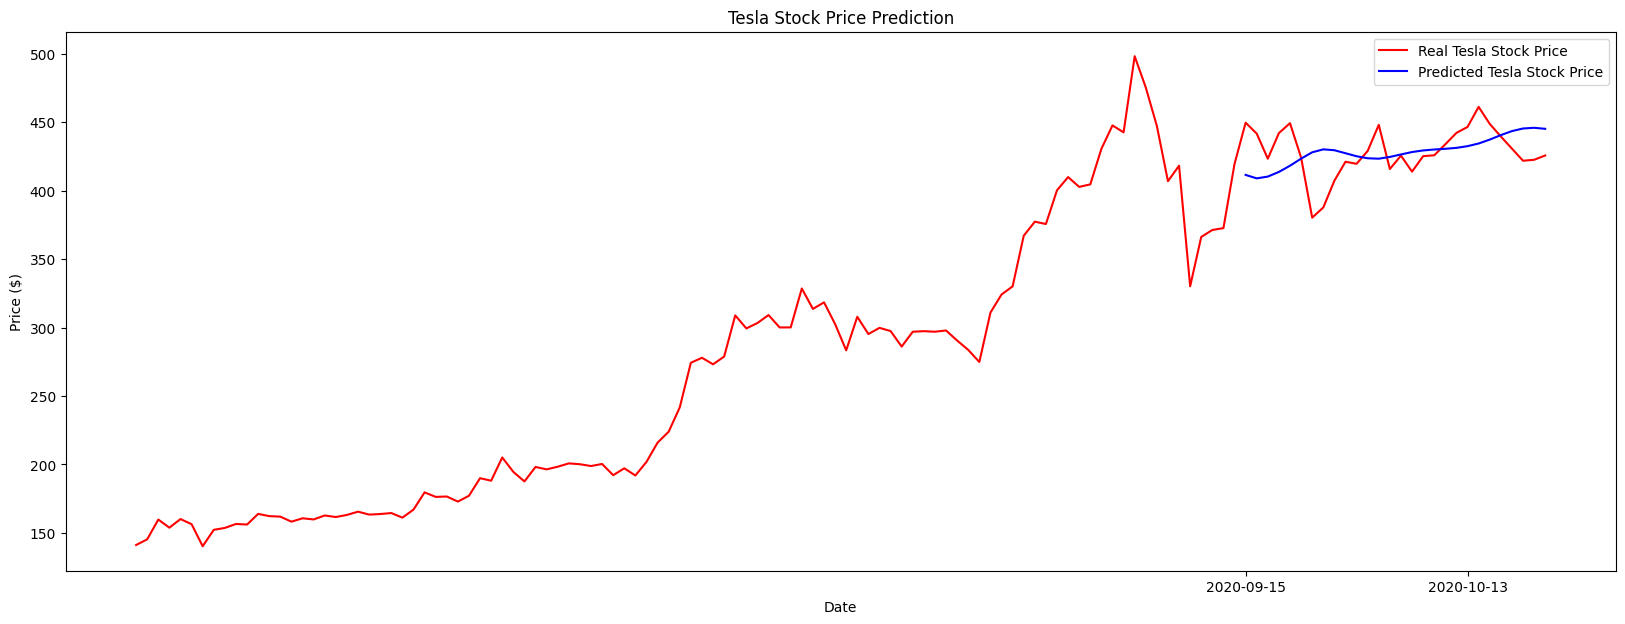

In [43]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[1800:], df_volume[1800:], color = 'red', label = 'Real Tesla Stock Price')
plt.plot(df['Date'][-predict.shape[0]:].values, predict, color = 'blue', label = 'Predicted Tesla Stock Price')
plt.xticks(np.arange(100,df[1800:].shape[0],20))
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [44]:
pred_ = predict[-1].copy()
prediction_full = []
window = 60
df_copy = df.iloc[:, 1:2][1:].values

for j in range(20):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_shape]
    test_ = df_[num_shape:]

    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = modelGRU.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

1/1 [==============================] - 0s 48ms/step


In [45]:
prediction_full_new = np.vstack((predict, np.array(prediction_full).reshape(-1,1)))

df_date = df[['Date']]

for h in range(20):
    kk = pd.to_datetime(df_date['Date'].iloc[-1]) + pd.DateOffset(days=1)
    kk = pd.DataFrame([kk.strftime("%Y-%m-%d")], columns=['Date'])
    df_date = df_date.append(kk)
df_date = df_date.reset_index(drop=True)

<ipython-input-45-0f8427136fd1>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_date = df_date.append(kk)
<ipython-input-45-0f8427136fd1>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_date = df_date.append(kk)
<ipython-input-45-0f8427136fd1>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_date = df_date.append(kk)
<ipython-input-45-0f8427136fd1>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_date = df_date.append(kk)
<ipython-input-45-0f8427136fd1>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_date = df_date.append(kk)
<ipyt

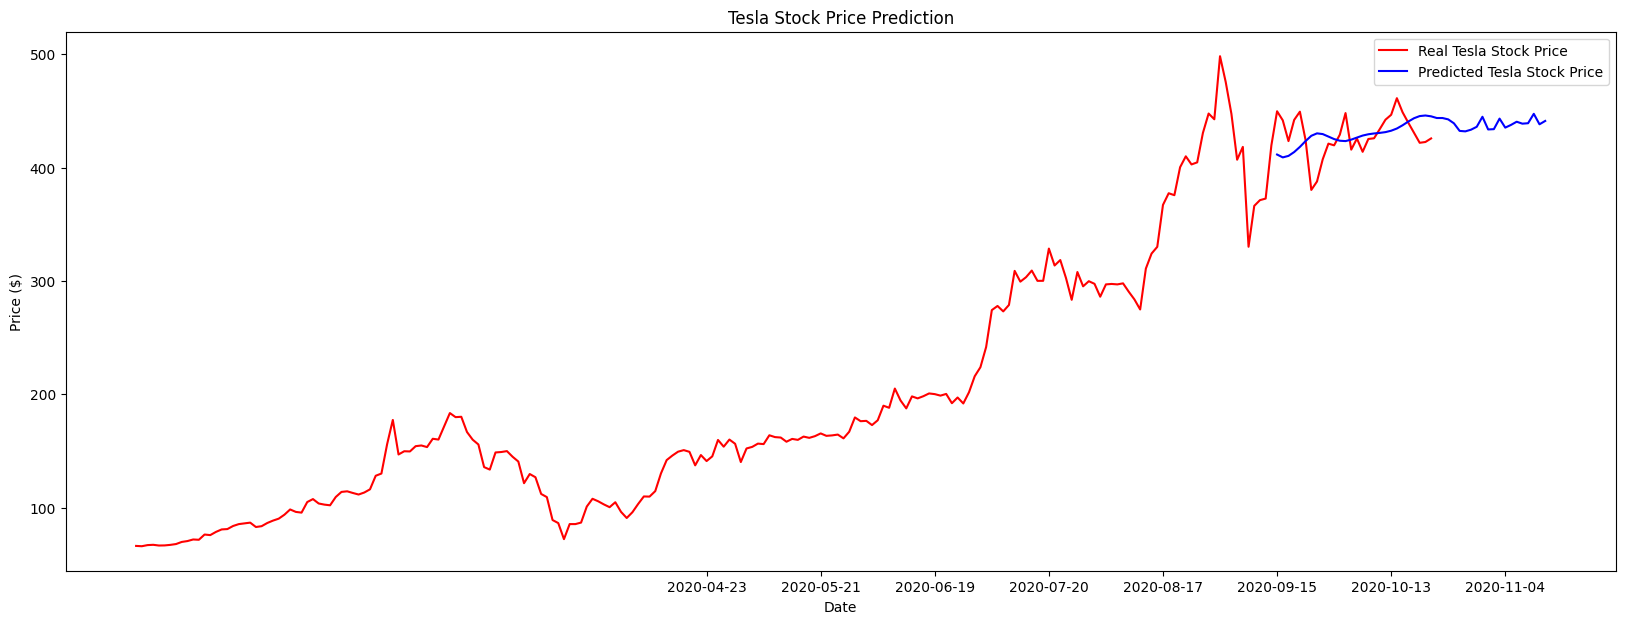

In [46]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[1700:], df_volume[1700:], color = 'red', label = 'Real Tesla Stock Price')
plt.plot(df_date['Date'][-prediction_full_new.shape[0]:].values, prediction_full_new, color = 'blue', label = 'Predicted Tesla Stock Price')
plt.xticks(np.arange(100,df_date[1700:].shape[0],20))
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()